In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from google.colab import data_table
from google.colab import drive

In [3]:
!pip install xgboost==1.7.5 --upgrade  # Install the specific version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
traffic_stops_df = pd.read_csv('/content/drive/MyDrive/DSBA6156_project/preprocessed_df.csv')

In [5]:
traffic_stops_df.head()

,ï»¿OBJECTID,Month_of_Stop,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,Was_a_Search_Conducted,Result_of_Stop,CMPD_Division,GlobalID
0,1,2019/11,Speeding,White,Male,12.0,Asian,Non-Hispanic,Female,39,NO,Citation Issued,South Division,{A45CF4CD-282F-4030-A160-72773A3B4730}
1,2,2019/11,Speeding,White,Male,21.0,White,Non-Hispanic,Female,24,NO,Citation Issued,Independence Division,{B03798C2-6FB5-4ED5-A15C-1BCBDA3C27D5}
2,3,2019/11,Speeding,Asian / Pacific Islander,Male,11.0,White,Non-Hispanic,Male,27,NO,Citation Issued,Independence Division,{AB78EFFB-CB43-4488-B244-6E845DB18222}
3,4,2019/11,Speeding,White,Male,13.0,Black,Non-Hispanic,Female,20,NO,Citation Issued,University City Division,{1BF01CA7-E08A-4C3A-8FDD-2EF1A1AEB2D0}
4,5,2019/11,Vehicle Regulatory,White,Male,22.0,White,Non-Hispanic,Female,33,NO,Citation Issued,Independence Division,{7EEB79D4-2FF9-48F7-AC4B-4FC5F8A13EF8}


In [6]:
# Define categorical and numerical features
categorical_features = ['Reason_for_Stop', 'Officer_Gender', 'Driver_Race', 'Driver_Ethnicity', 'Driver_Gender', 'CMPD_Division']
numerical_features = ['Driver_Age']

In [7]:
# Initialize scaler

scaler = MinMaxScaler()
# Fit the scaler to the training data
scaler.fit(traffic_stops_df[numerical_features])

MinMaxScaler()

In [8]:
# Define features and target
features = traffic_stops_df[['Driver_Age', 'Reason_for_Stop', 'Officer_Gender', 'Driver_Race', 'Driver_Ethnicity', 'Driver_Gender', 'CMPD_Division']]
target = traffic_stops_df['Result_of_Stop']

In [9]:
# Encode categorical features into dummy variables
X = pd.get_dummies(features, columns=categorical_features, drop_first=True)

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

In [11]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

In [12]:
# Fit the encoder to the target variable and transform it
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [13]:
# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='hist')

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
# # Set up the parameters for grid search
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 1],
#     'colsample_bytree': [0.8, 1]
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)

In [ ]:
# # Fit the model
# grid_search.fit(X_train, y_train_encoded)

# # Output the best parameters
# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

In [14]:
# prompt: define xgboost model with these Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1}

# Initialize the XGBoost classifier with the best parameters
best_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.2,
    max_depth=7,
    n_estimators=300,
    subsample=1,
    use_label_encoder=False,
    eval_metric='aucpr',
    tree_method='hist'
)

In [15]:
# prompt: train the model

# Train the best model
best_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test_encoded, y_pred))
print(confusion_matrix(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.06      0.11      5629
           1       0.62      0.55      0.58     92915
           2       0.50      0.11      0.18      5548
           3       0.64      0.80      0.71    125223
           4       0.37      0.04      0.08     13677

    accuracy                           0.63    242992
   macro avg       0.54      0.31      0.33    242992
weighted avg       0.61      0.63      0.60    242992

[[   328    926     67   4304      4]
 [    49  50659    196  41520    491]
 [    60    924    619   3939      6]
 [   125  23847    335 100441    475]
 [     5   5654     17   7419    582]]


In [21]:
# Save the model to a file
filename = 'outcome_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

# Save the scaler
scaler_filename = 'outcome_scaler.pkl'
pickle.dump(scaler, open(scaler_filename, 'wb'))

# Save the encoder with class labels
label_encoder.classes_ = label_encoder.classes_  # Assign the classes to an attribute
encoder_filename = 'outcome_encoder.pkl'
pickle.dump(label_encoder, open(encoder_filename, 'wb'))

In [25]:
import joblib

# Assuming 'scaler' and 'encoder' are the fitted scaler and encoder objects
joblib.dump(scaler, 'outcome_scaler.joblib')
joblib.dump(label_encoder, 'outcome_encoder.joblib')

['outcome_encoder.joblib']

In [ ]:
# # Get the best model from grid search
# best_model = grid_search.best_estimator_

In [ ]:
# Evaluate the model
y_pred_xgb = best_model.predict(X_test)


XGBoost Feature Importances:

                                   Feature  Importance
6                 Reason_for_Stop_Speeding    0.311503
8        Reason_for_Stop_Vehicle Equipment    0.087814
2            Reason_for_Stop_Investigation    0.073405
7          Reason_for_Stop_Stop Light/Sign    0.060298
1   Reason_for_Stop_Driving While Impaired    0.058288
4            Reason_for_Stop_Safe Movement    0.058103
9       Reason_for_Stop_Vehicle Regulatory    0.055541
24       CMPD_Division_Providence Division    0.044166
18          CMPD_Division_Freedom Division    0.035695
3                    Reason_for_Stop_Other    0.023285
25            CMPD_Division_South Division    0.018163
5                 Reason_for_Stop_SeatBelt    0.015211
17          CMPD_Division_Eastway Division    0.014841
21            CMPD_Division_Metro Division    0.013647
13               Driver_Race_Other/Unknown    0.013639
27  CMPD_Division_University City Division    0.012860
15           Driver_Ethnicity_Non-

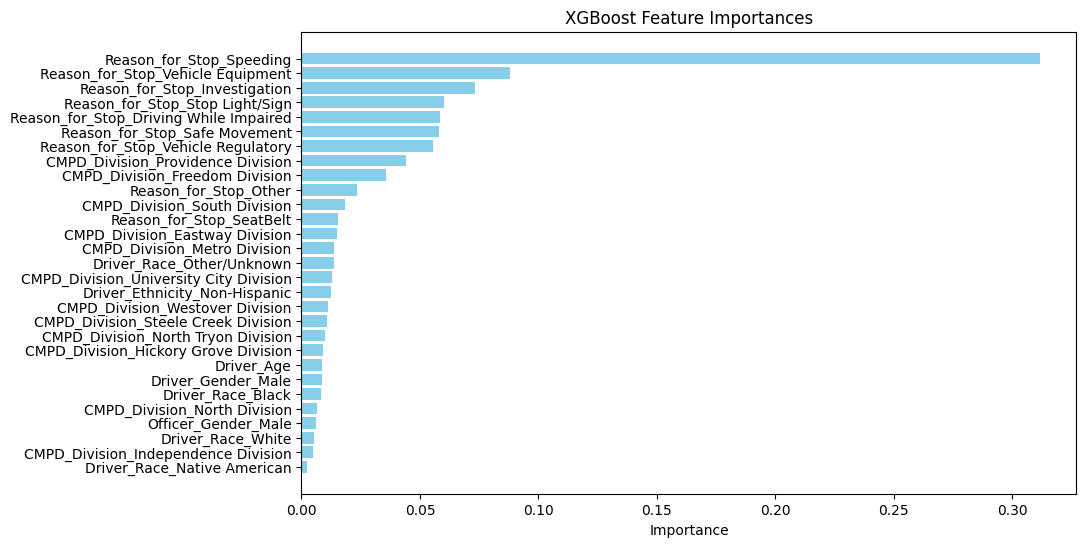

ValueError: Mix of label input types (string and number)

In [19]:
# # Evaluate the model
# print("\nXGBoost Classification Report:\n")
# print(classification_report(y_test, y_pred_xgb))

# Feature Importance
feature_importances_xgb = best_model.feature_importances_
features_xgb = X_train.columns
importance_df_xgb = pd.DataFrame({'Feature': features_xgb, 'Importance': feature_importances_xgb})
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)
print("\nXGBoost Feature Importances:\n")
print(importance_df_xgb)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_xgb['Feature'], importance_df_xgb['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='g')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# AUC Score and ROC Curve
y_prob_xgb = best_model.predict_proba(X_test)[:, 1]
auc_score_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"\nXGBoost AUC Score: {auc_score_xgb:.2f}")

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('XGBoost ROC Curve')
plt.show()

In [20]:
# Print the class labels and their corresponding numerical values
class_labels = label_encoder.classes_
encoded_values = label_encoder.transform(class_labels)
print("Class Labels and Encoded Values:")
for label, value in zip(class_labels, encoded_values):
    print(f"{label}: {value}")

Class Labels and Encoded Values:
Arrest: 0
Citation Issued: 1
No Action Taken: 2
Verbal Warning: 3
Written Warning: 4


In [22]:
X.head()

,Driver_Age,Reason_for_Stop_Driving While Impaired,Reason_for_Stop_Investigation,Reason_for_Stop_Other,Reason_for_Stop_Safe Movement,Reason_for_Stop_SeatBelt,Reason_for_Stop_Speeding,Reason_for_Stop_Stop Light/Sign,Reason_for_Stop_Vehicle Equipment,Reason_for_Stop_Vehicle Regulatory,...,CMPD_Division_Hickory Grove Division,CMPD_Division_Independence Division,CMPD_Division_Metro Division,CMPD_Division_North Division,CMPD_Division_North Tryon Division,CMPD_Division_Providence Division,CMPD_Division_South Division,CMPD_Division_Steele Creek Division,CMPD_Division_University City Division,CMPD_Division_Westover Division
0,39,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,24,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,27,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,20,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,33,False,False,False,False,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False


In [24]:
best_model.save_model('outcome_model.json')


In [ ]:
import joblib

# Assuming 'scaler' and 'encoder' are the fitted scaler and encoder objects
joblib.dump(outcome_scaler, 'outcome_scaler.joblib')
joblib.dump(outcome_encoder, 'outcome_encoder.joblib')

In [6]:
data = pd.read_csv('/content/drive/MyDrive/DSBA6156_project/preprocessed_df.csv')

In [44]:
data.head(4)

,ï»¿OBJECTID,Month_of_Stop,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,Was_a_Search_Conducted,Result_of_Stop,CMPD_Division,GlobalID
0,1,2019/11,Speeding,White,Male,12.0,Asian,Non-Hispanic,Female,39,NO,Citation Issued,South Division,{A45CF4CD-282F-4030-A160-72773A3B4730}
1,2,2019/11,Speeding,White,Male,21.0,White,Non-Hispanic,Female,24,NO,Citation Issued,Independence Division,{B03798C2-6FB5-4ED5-A15C-1BCBDA3C27D5}
2,3,2019/11,Speeding,Asian / Pacific Islander,Male,11.0,White,Non-Hispanic,Male,27,NO,Citation Issued,Independence Division,{AB78EFFB-CB43-4488-B244-6E845DB18222}
3,4,2019/11,Speeding,White,Male,13.0,Black,Non-Hispanic,Female,20,NO,Citation Issued,University City Division,{1BF01CA7-E08A-4C3A-8FDD-2EF1A1AEB2D0}


In [28]:
# Define features and target
X = data[['Reason_for_Stop', 'Officer_Gender', 'Driver_Race', 'Driver_Ethnicity', 'Driver_Gender', 'Driver_Age', 'CMPD_Division']]
y = data['Result_of_Stop']

In [32]:
# Encode the target variable
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

In [36]:
# Convert categorical features to 'category' dtype
categorical_columns = ['Reason_for_Stop', 'Officer_Gender', 'Driver_Race', 'Driver_Ethnicity', 'Driver_Gender', 'CMPD_Division']
X[categorical_columns] = X[categorical_columns].astype('category')

<ipython-input-36-1f171dc2c006>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_columns] = X[categorical_columns].astype('category')


In [37]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [40]:
# Train the XGBoost model
xgb_model = XGBClassifier(
    learning_rate=0.2,
    max_depth=10,
    n_estimators=150,
    subsample=0.8,
    tree_method='hist',
    random_state=42,
    enable_categorical=True,  # Enable categorical support
    use_label_encoder=False,
    eval_metric='logloss'
)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [41]:
# Fit the model directly with raw categorical and numerical features
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [42]:
# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC Score: {auc_score:.2f}")

# Save the model and encoder
xgb_model.save_model('outcome_model.json')
joblib.dump(y_encoder, 'outcome_encoder.joblib')

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.06      0.11      3745
           1       0.61      0.56      0.58     61543
           2       0.43      0.12      0.19      3758
           3       0.64      0.79      0.71     83876
           4       0.37      0.04      0.08      9073

    accuracy                           0.63    161995
   macro avg       0.51      0.32      0.33    161995
weighted avg       0.61      0.63      0.60    161995

AUC Score: 0.75


['outcome_encoder.joblib']

In [48]:
# prompt: use this test data, test_input_data = {
#     'Reason_for_Stop': 'Stop Light/Sign',
#     'Officer_Gender': 'Male',
#     'Driver_Race': 'White',
#     'Driver_Ethnicity': 'Non-Hispanic',
#     'Driver_Gender': 'Male',
#     'Driver_Age': 21,
#     'CMPD_Division': 'Metro Division'
# }
# in the model to check what the outcome probabilities are

import pandas as pd
import numpy as np
import joblib
from xgboost import XGBClassifier

# Load the saved model and preprocessing objects
model = XGBClassifier()
model.load_model('outcome_model.json')
encoder = joblib.load('outcome_encoder.joblib')
scaler = joblib.load('outcome_scaler.joblib')

# Input data
test_input_data = {
    'Reason_for_Stop': 'Driving While Impaired',
    'Officer_Gender': 'Male',
    'Driver_Race': 'Black',
    'Driver_Ethnicity': 'Non-Hispanic',
    'Driver_Gender': 'Male',
    'Driver_Age': 25,
    'CMPD_Division': 'Metro Division'
}

# Create a DataFrame from the input data
input_df = pd.DataFrame([test_input_data])

# Convert categorical features to 'category' dtype
categorical_columns = ['Reason_for_Stop', 'Officer_Gender', 'Driver_Race', 'Driver_Ethnicity', 'Driver_Gender', 'CMPD_Division']
input_df[categorical_columns] = input_df[categorical_columns].astype('category')

# Make predictions
prediction = model.predict(input_df)
probabilities = model.predict_proba(input_df)

# Decode the prediction
decoded_prediction = encoder.inverse_transform(prediction)

# Print the results
print(f"Predicted Outcome: {decoded_prediction[0]}")
print("Outcome Probabilities:")
for class_label, prob in zip(encoder.classes_, probabilities[0]):
    print(f"{class_label}: {prob:.4f}")

Predicted Outcome: Citation Issued
Outcome Probabilities:
Arrest: 0.0137
Citation Issued: 0.8230
No Action Taken: 0.0318
Verbal Warning: 0.1272
Written Warning: 0.0043


In [43]:
# prompt: extract feature importance from the xgb_model

# Feature Importance
feature_importances_xgb = xgb_model.feature_importances_
features_xgb = X_train.columns
importance_df_xgb = pd.DataFrame({'Feature': features_xgb, 'Importance': feature_importances_xgb})
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)
print("\nXGBoost Feature Importances:\n")
importance_df_xgb


XGBoost Feature Importances:



,Feature,Importance
0,Reason_for_Stop,0.457055
6,CMPD_Division,0.134627
3,Driver_Ethnicity,0.097363
2,Driver_Race,0.085831
5,Driver_Age,0.078689
4,Driver_Gender,0.074884
1,Officer_Gender,0.071552


In [50]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 9.6 MB/s eta 0:00:00


In [4]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
# Define features and target
X = data[['Reason_for_Stop', 'Officer_Gender', 'Driver_Race', 'Driver_Ethnicity', 'Driver_Gender', 'Driver_Age', 'CMPD_Division']]
y = data['Result_of_Stop']

In [8]:
# Encode the target variable
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

In [9]:
# Convert categorical features to 'category' dtype
categorical_columns = ['Reason_for_Stop', 'Officer_Gender', 'Driver_Race', 'Driver_Ethnicity', 'Driver_Gender', 'CMPD_Division']
X[categorical_columns] = X[categorical_columns].astype('category')

<ipython-input-9-1f171dc2c006>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_columns] = X[categorical_columns].astype('category')


In [10]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [56]:
# Define the LightGBM model
lgb_model = lgb.LGBMClassifier(objective='multiclass', random_state=42)

In [57]:
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [-1, 5, 10, 15],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5]
}

In [58]:
# Perform random search
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [59]:
# Fit the model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 647977, number of used features: 7
[LightGBM] [Info] Start training from score -3.767006
[LightGBM] [Info] Start training from score -0.967833
[LightGBM] [Info] Start training from score -3.763607
[LightGBM] [Info] Start training from score -0.658233
[LightGBM] [Info] Start training from score -2.882258


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(objective='multiclass',
                                            random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [-1, 5, 10, 15],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [50, 100, 200, 300],
                                        'num_leaves': [15, 31, 63, 127],
                                        'reg_alpha': [0.0, 0.1, 0.5],
                                        'reg_lambda': [0.0, 0.1, 0.5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [60]:
# Retrieve the best model
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC Score: {auc_score:.2f}")


Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'num_leaves': 15, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.2, 'colsample_bytree': 0.6}

Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.06      0.10      3745
           1       0.62      0.56      0.58     61543
           2       0.58      0.11      0.18      3758
           3       0.64      0.80      0.71     83876
           4       0.41      0.03      0.05      9073

    accuracy                           0.63    161995
   macro avg       0.57      0.31      0.33    161995
weighted avg       0.62      0.63      0.60    161995

AUC Score: 0.76


In [11]:
# prompt: create lgbm model with these parameters Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'num_leaves': 15, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.2, 'colsample_bytree': 0.6}

# Define the LightGBM model with the best parameters
lgb_model = lgb.LGBMClassifier(subsample= 1.0, reg_lambda= 0.1, reg_alpha= 0.0, num_leaves= 15, n_estimators= 300, min_child_weight= 1, max_depth= 15, learning_rate= 0.2, colsample_bytree= 0.6, objective='multiclass', random_state=42)

# Fit the model
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)

# Evaluate the model
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC Score: {auc_score:.2f}")

# Save the model
lgb_model.booster_.save_model('lgbm_outcome_model.txt')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 647977, number of used features: 7
[LightGBM] [Info] Start training from score -3.767006
[LightGBM] [Info] Start training from score -0.967833
[LightGBM] [Info] Start training from score -3.763607
[LightGBM] [Info] Start training from score -0.658233
[LightGBM] [Info] Start training from score -2.882258

Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.06      0.10      3745
           1       0.62      0.56      0.58     61543
           2       0.58      0.11      0.18      3758
           3       0.64      0.80      0.71     83876
           4       0.41      0.03      0.05      9073

    accuracy                           0.63    161995
   macro avg       0.57      0.31    

In [12]:
# Feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n")
print(importance_df)


Feature Importances:

            Feature  Importance
5        Driver_Age        6568
6     CMPD_Division        4377
0   Reason_for_Stop        3473
2       Driver_Race        2046
1    Officer_Gender        1547
4     Driver_Gender        1523
3  Driver_Ethnicity        1466


In [14]:
# prompt: I want the feature importance percentages from the model. there is no dataframe use the lgbm_model

# Calculate feature importance percentages
importance_percentages = (lgb_model.feature_importances_ / lgb_model.feature_importances_.sum()) * 100

# Create a DataFrame for feature importance percentages
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance (%)': importance_percentages
}).sort_values(by='Importance (%)', ascending=False)

print("\nFeature Importances (%):\n")
importance_df


Feature Importances (%):



,Feature,Importance (%)
5,Driver_Age,31.276190
6,CMPD_Division,20.842857
0,Reason_for_Stop,16.538095
2,Driver_Race,9.742857
1,Officer_Gender,7.366667
4,Driver_Gender,7.252381
3,Driver_Ethnicity,6.980952


In [61]:
# Feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n")
print(importance_df)


Feature Importances:

            Feature  Importance
5        Driver_Age        6568
6     CMPD_Division        4377
0   Reason_for_Stop        3473
2       Driver_Race        2046
1    Officer_Gender        1547
4     Driver_Gender        1523
3  Driver_Ethnicity        1466


In [65]:
# Save the model to JSON format
best_model.booster_.save_model('lgbm_outcome_model.json')  # Remove format='json'
joblib.dump(y_encoder, 'lgbm_outcome_encoder.joblib')

['lgbm_outcome_encoder.joblib']